# Experimental Orchestration Pipeline

In [1]:
!pip install torch torchvision scikit-learn hdbscan plotly umap-learn opencv-python pycocotools

In [2]:
import torch
import torchvision
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.models as models 
import pytorch_lightning as pl
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
import hdbscan
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from tqdm.notebook import tqdm
from pycocotools import mask as mask_util

<h2>Defining Functions</h2>

<h4>Pipeline Configuration</h4>

In [3]:
# Pipeline Configuration
@dataclass
class PipelineConfig:
    """Configuration for the tree crown pipeline"""
    # Paths
    image_path: str
    maskrcnn_checkpoint: str
    autoencoder_checkpoint: str
    output_dir: str = "outputs"
    
    # Image sizes
    original_size: int = 1024
    maskrcnn_size: int = 500
    autoencoder_size: int = 512
    
    # Detection thresholds
    mask_threshold: float = 0.5
    score_threshold: float = 0.5
    
    # Clustering
    clustering_method: str = "HDBSCAN"  # "DBSCAN" or "HDBSCAN"
    subset_ratio: float = 0.25  # Use 25% for parameter optimization
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

<h4>Model Loading</h4>

In [4]:
# Model Loading
class PredictionProcessor:
    """Process Mask R-CNN predictions"""
    def __init__(self, mask_threshold=0.5, score_threshold=0.5):
        self.mask_threshold = mask_threshold
        self.score_threshold = score_threshold
    
    def __call__(self, predictions):
        """Filter predictions by score threshold"""
        if isinstance(predictions, list):
            predictions = predictions[0]
        
        # Filter by score
        keep = predictions['scores'] > self.score_threshold
        
        filtered = {
            'boxes': predictions['boxes'][keep],
            'masks': predictions['masks'][keep],
            'scores': predictions['scores'][keep],
            'labels': predictions['labels'][keep]
        }
        
        # Threshold masks
        filtered['masks'] = (filtered['masks'] > self.mask_threshold).squeeze(1)
        
        return filtered


In [5]:
class LitMaskRCNN(pl.LightningModule):
    """PyTorch Lightning Mask R-CNN Module"""
    def __init__(self, lr=1e-3, num_classes=2, mask_threshold=0.5, score_threshold=0.5):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pretrained Mask R-CNN with ResNet50 FPN backbone
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
        
        # Replace box predictor head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = \
            torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        
        # Replace mask predictor head
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = \
            torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
                in_features_mask, hidden_layer, num_classes
            )
        
        # Prediction post-processor
        self.pred_processor = PredictionProcessor(
            mask_threshold=mask_threshold,
            score_threshold=score_threshold
        )
    
    def forward(self, images, targets=None):
        return self.model(images, targets)


In [6]:
def load_maskrcnn(checkpoint_path: str, config: PipelineConfig) -> LitMaskRCNN:
    """Load Mask R-CNN model from checkpoint"""
    print(f"Loading Mask R-CNN from {checkpoint_path}...")
    model = LitMaskRCNN.load_from_checkpoint(
        checkpoint_path,
        mask_threshold=config.mask_threshold,
        score_threshold=config.score_threshold
    )
    model.eval()
    model.to(config.device)
    print("✓ Mask R-CNN loaded successfully")
    return model

In [7]:
def load_autoencoder(checkpoint_path: str, config: PipelineConfig, model_class):
    """Load autoencoder model from .pth file"""
    print(f"Loading Autoencoder from {checkpoint_path}...")
    model = model_class  # Initialize your TreeCrownResNet34 or similar
    model.load_state_dict(torch.load(checkpoint_path, map_location=config.device))
    model.eval()
    model.to(config.device)
    print("✓ Autoencoder loaded successfully")
    return model

<h4>Image Processing and Detection</h4>

In [8]:
def load_and_preprocess_image(image_path: str, target_size: int) -> Tuple[torch.Tensor, np.ndarray]:
    """
    Load image and prepare for Mask R-CNN inference
    
    Returns:
        torch_image: (C, H, W) tensor for model input
        original_np: (H, W, C) numpy array for visualization
    """
    # Load image
    image = Image.open(image_path).convert('RGB')
    original_np = np.array(image)
    
    # Resize to target size
    image_resized = image.resize((target_size, target_size), Image.BILINEAR)
    
    # Convert to tensor and normalize
    image_tensor = torchvision.transforms.functional.to_tensor(image_resized)
    
    return image_tensor, original_np

In [9]:
def run_detection(model: LitMaskRCNN, image_tensor: torch.Tensor, config: PipelineConfig) -> Dict:
    """Run Mask R-CNN detection on image"""
    print("Running Mask R-CNN detection...")
    
    with torch.no_grad():
        image_batch = image_tensor.unsqueeze(0).to(config.device)
        predictions = model(image_batch)
        predictions_processed = model.pred_processor(predictions)
    
    # Move to CPU
    for key in predictions_processed:
        predictions_processed[key] = predictions_processed[key].cpu()
    
    num_detections = len(predictions_processed['scores'])
    print(f"✓ Detected {num_detections} tree crowns")
    
    return predictions_processed

In [10]:
def scale_predictions(predictions: Dict, from_size: int, to_size: int) -> Dict:
    """Scale prediction coordinates from one size to another"""
    scale_factor = to_size / from_size
    
    scaled_preds = predictions.copy()
    scaled_preds['boxes'] = predictions['boxes'] * scale_factor
    
    # Scale masks
    masks = predictions['masks'].numpy()
    scaled_masks = []
    for mask in masks:
        scaled_mask = cv2.resize(
            mask.astype(np.uint8),
            (to_size, to_size),
            interpolation=cv2.INTER_NEAREST
        )
        scaled_masks.append(scaled_mask)
    
    scaled_preds['masks'] = torch.from_numpy(np.array(scaled_masks))
    
    return scaled_preds

<h4>Mask Cropping and Feature Extraction</h4>

In [11]:
def crop_masks(image_np: np.ndarray, predictions: Dict, config: PipelineConfig) -> List[np.ndarray]:
    """
    Crop individual tree crown masks with transparent background
    
    Returns:
        List of RGBA images (H, W, 4) with transparent backgrounds
    """
    print("Cropping individual tree crown masks...")
    crops = []
    
    boxes = predictions['boxes'].numpy()
    masks = predictions['masks'].numpy()
    
    for i, (box, mask) in enumerate(zip(boxes, masks)):
        x1, y1, x2, y2 = box.astype(int)
        
        # Clip to image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2 = min(image_np.shape[1], x2)
        y2 = min(image_np.shape[0], y2)
        
        # Crop image and mask
        crop_rgb = image_np[y1:y2, x1:x2]
        crop_mask = mask[y1:y2, x1:x2]
        
        # Create RGBA with transparent background
        crop_rgba = np.zeros((*crop_rgb.shape[:2], 4), dtype=np.uint8)
        crop_rgba[:, :, :3] = crop_rgb
        crop_rgba[:, :, 3] = (crop_mask * 255).astype(np.uint8)
        
        crops.append(crop_rgba)
    
    print(f"✓ Created {len(crops)} mask crops")
    return crops

In [12]:
def resize_crops(crops: List[np.ndarray], target_size: int) -> List[np.ndarray]:
    """Resize crops to target size for autoencoder"""
    resized = []
    for crop in crops:
        resized_crop = cv2.resize(crop, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
        resized.append(resized_crop)
    return resized

In [13]:
def extract_features(autoencoder, crops: List[np.ndarray], config: PipelineConfig) -> np.ndarray:
    """
    Extract latent features from crops using autoencoder
    
    Returns:
        features: (N, latent_dim) numpy array
    """
    print("Extracting latent features from autoencoder...")
    
    features_list = []
    
    # Process in batches
    batch_size = 16
    for i in range(0, len(crops), batch_size):
        batch_crops = crops[i:i + batch_size]
        
        # Convert to tensor (take RGB channels only)
        batch_tensors = []
        for crop in batch_crops:
            # Convert RGBA to RGB and normalize
            rgb = crop[:, :, :3].astype(np.float32) / 255.0
            tensor = torch.from_numpy(rgb).permute(2, 0, 1)  # (C, H, W)
            batch_tensors.append(tensor)
        
        batch = torch.stack(batch_tensors).to(config.device)
        
        # Extract features
        with torch.no_grad():
            latent = autoencoder.encode(batch)
            features_list.append(latent.cpu().numpy())
    
    features = np.vstack(features_list)
    print(f"✓ Extracted features with shape {features.shape}")
    
    return features

In [14]:
def optimize_clustering_parameters(
    features: np.ndarray,
    config: PipelineConfig,
    param_grid: Optional[Dict] = None
) -> Tuple[Dict, float]:
    """
    Optimize clustering parameters using grid search on subset
    
    Returns:
        best_params: Dictionary of best parameters
        best_score: Best silhouette score achieved
    """
    print("\nOptimizing clustering parameters...")
    
    # Sample subset
    n_samples = len(features)
    subset = features
    
    print(f"Using {n_samples} samples for optimization")
    
    # Default parameter grids
    if param_grid is None:
        if config.clustering_method == "DBSCAN":
            param_grid = {
                'eps': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
                'min_samples': [3, 5, 10, 15, 20]
            }
        else:  # HDBSCAN
            param_grid = {
                'min_cluster_size': [10, 15, 20, 30, 50],
                'min_samples': [3, 5, 10, 15]
            }
    
    best_score = -1
    best_params = None
    results = []
    
    # Grid search
    if config.clustering_method == "DBSCAN":
        for eps in param_grid['eps']:
            for min_samples in param_grid['min_samples']:
                clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                labels = clusterer.fit_predict(subset)
                
                # Calculate metrics (only if we have more than 1 cluster)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters > 1:
                    # Filter out noise for scoring
                    mask = labels != -1
                    if mask.sum() > 1:
                        score = silhouette_score(subset[mask], labels[mask])
                        noise_ratio = (labels == -1).sum() / len(labels)
                        
                        results.append({
                            'eps': eps,
                            'min_samples': min_samples,
                            'silhouette': score,
                            'n_clusters': n_clusters,
                            'noise_ratio': noise_ratio
                        })
                        
                        if score > best_score:
                            best_score = score
                            best_params = {'eps': eps, 'min_samples': min_samples}
    
    else:  # HDBSCAN
        for min_cluster_size in param_grid['min_cluster_size']:
            for min_samples in param_grid['min_samples']:
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    metric='euclidean'
                )
                labels = clusterer.fit_predict(subset)
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters > 1:
                    mask = labels != -1
                    if mask.sum() > 1:
                        score = silhouette_score(subset[mask], labels[mask])
                        noise_ratio = (labels == -1).sum() / len(labels)
                        
                        results.append({
                            'min_cluster_size': min_cluster_size,
                            'min_samples': min_samples,
                            'silhouette': score,
                            'n_clusters': n_clusters,
                            'noise_ratio': noise_ratio
                        })
                        
                        if score > best_score:
                            best_score = score
                            best_params = {
                                'min_cluster_size': min_cluster_size,
                                'min_samples': min_samples
                            }
    
    if best_params is None:
        print("⚠ No valid clustering found during optimization. Using default parameters.")
    if config.clustering_method == "DBSCAN":
        best_params = {'eps': 2.0, 'min_samples': 2}
        best_score = 0.0
    else:  # HDBSCAN
        best_params = {'min_cluster_size': 2, 'min_samples': 1}
        best_score = 0.0

    print(f"✓ Best parameters: {best_params}")
    print(f"✓ Best silhouette score: {best_score:.3f}")
    
    return best_params, best_score

In [15]:
def cluster_features(features: np.ndarray, config: PipelineConfig, params: Dict) -> np.ndarray:
    """
    Cluster features using optimized parameters
    
    Returns:
        labels: Cluster assignments for each sample
    """
    print(f"\nClustering all {len(features)} samples...")
    
    if config.clustering_method == "DBSCAN":
        clusterer = DBSCAN(**params, metric='euclidean')
    else:
        clusterer = hdbscan.HDBSCAN(**params, metric='euclidean')
    
    labels = clusterer.fit_predict(features)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_ratio = n_noise / len(labels) * 100
    
    print(f"✓ Found {n_clusters} clusters")
    print(f"✓ Noise samples: {n_noise} ({noise_ratio:.1f}%)")
    
    return labels

<h4>JSON Export (COCO Format)</h4>

In [16]:
def predictions_to_coco_json(
    predictions: Dict,
    labels: np.ndarray,
    image_path: str,
    config: PipelineConfig,
    clustering_params: Dict,
    silhouette: float
) -> Dict:
    """
    Convert predictions and cluster labels to COCO format JSON
    """
    print("\nCreating COCO format JSON...")
    
    # Generate cluster colors
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    # Use a color palette
    colors = px.colors.qualitative.Plotly + px.colors.qualitative.Set3
    cluster_colors = {}
    for i, label in enumerate(unique_labels):
        if label == -1:
            cluster_colors[-1] = "#808080"  # Grey for noise
        else:
            cluster_colors[label] = colors[i % len(colors)]
    
    # Count crowns per cluster
    cluster_counts = {int(label): int((labels == label).sum()) for label in unique_labels}
    
    # Build annotations
    annotations = []
    boxes = predictions['boxes'].numpy()
    masks = predictions['masks'].numpy()
    scores = predictions['scores'].numpy()
    
    for i, (box, mask, score, label) in enumerate(zip(boxes, masks, scores, labels)):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        # Convert mask to RLE
        mask_fortran = np.asfortranarray(mask.astype(np.uint8))
        rle = mask_util.encode(mask_fortran)
        rle['counts'] = rle['counts'].decode('utf-8')  # Convert bytes to string
        
        annotation = {
            "id": int(i),
            "tile_position": {"row": 0, "col": 0},  # Single image, no tiling yet
            "bbox": [float(x1), float(y1), float(w), float(h)],
            "segmentation": rle,
            "area": float(mask.sum()),
            "confidence": float(score),
            "cluster_id": int(label)
        }
        annotations.append(annotation)
    
    # Build full COCO structure
    coco_output = {
        "metadata": {
            "image_file": str(image_path),
            "image_dimensions": [config.original_size, config.original_size],
            "tile_size": config.original_size,
            "tile_overlap_percent": 0,  # Single image
            "total_tiles": 1,
            "clustering_algorithm": config.clustering_method,
            "clustering_params": clustering_params,
            "silhouette_score": float(silhouette)
        },
        "annotations": annotations,
        "clusters": {
            str(label): {
                "count": cluster_counts[label],
                "color": cluster_colors[label]
            }
            for label in unique_labels
        }
    }
    
    print(f"✓ Created {len(annotations)} annotations")
    return coco_output

In [17]:
def save_json(data: Dict, output_path: str):
    """Save data to JSON file"""
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"✓ Saved JSON to {output_path}")

<h4>Visualize Results</h4>

In [18]:
def visualize_results(
    image_np: np.ndarray,
    predictions: Dict,
    labels: np.ndarray,
    cluster_info: Dict,
    config: PipelineConfig
) -> go.Figure:
    """
    Create interactive Plotly visualization
    """
    print("\nCreating interactive visualization...")
    
    # Create subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Clustered Tree Crowns", "Cluster Statistics"),
        specs=[[{"type": "image"}, {"type": "bar"}]],
        column_widths=[0.7, 0.3]
    )
    
    # Prepare overlay image
    overlay = image_np.copy()
    masks = predictions['masks'].numpy()
    
    # Get cluster colors from cluster_info
    cluster_colors_hex = {int(k): v['color'] for k, v in cluster_info.items()}
    
    # Overlay masks with cluster colors
    for mask, label in zip(masks, labels):
        color_hex = cluster_colors_hex[int(label)]
        # Convert hex to RGB
        color_rgb = tuple(int(color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        
        # Apply colored mask with transparency
        colored_mask = np.zeros_like(overlay)
        colored_mask[mask > 0] = color_rgb
        overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)
    
    # Add image
    fig.add_trace(
        go.Image(z=overlay),
        row=1, col=1
    )
    
    # Add cluster statistics bar chart
    cluster_counts = [v['count'] for k, v in sorted(cluster_info.items()) if int(k) != -1]
    cluster_labels_list = [f"Cluster {k}" for k in sorted(cluster_info.keys()) if int(k) != -1]
    cluster_colors_list = [v['color'] for k, v in sorted(cluster_info.items()) if int(k) != -1]
    
    # Add noise separately if it exists
    if '-1' in cluster_info:
        cluster_labels_list.append("Noise")
        cluster_counts.append(cluster_info['-1']['count'])
        cluster_colors_list.append(cluster_info['-1']['color'])
    
    fig.add_trace(
        go.Bar(
            x=cluster_labels_list,
            y=cluster_counts,
            marker_color=cluster_colors_list,
            text=cluster_counts,
            textposition='auto',
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_xaxes(title_text="Cluster", row=1, col=2)
    fig.update_yaxes(title_text="Number of Crowns", row=1, col=2)
    
    # Add title with statistics
    total_crowns = len(labels)
    n_clusters = len([k for k in cluster_info.keys() if int(k) != -1])
    noise_pct = (cluster_info.get('-1', {}).get('count', 0) / total_crowns) * 100 if '-1' in cluster_info else 0
    
    title_text = (
        f"Tree Crown Segmentation Results<br>"
        f"<sub>Total Crowns: {total_crowns} | Clusters: {n_clusters} | "
        f"Noise: {noise_pct:.1f}%</sub>"
    )
    
    fig.update_layout(
        title_text=title_text,
        height=600,
        showlegend=False
    )
    
    print("✓ Visualization created")
    return fig


<h4>Main Pipeline</h4>

In [19]:
def run_pipeline(
    config: PipelineConfig,
    autoencoder_model,  # Pass your initialized TreeCrownResNet34 here
    param_grid: Optional[Dict] = None
) -> Tuple[Dict, go.Figure]:
    """
    Run the complete tree crown segmentation and clustering pipeline
    
    Args:
        config: Pipeline configuration
        autoencoder_model: Your initialized autoencoder model class
        param_grid: Optional custom parameter grid for clustering
    
    Returns:
        coco_json: COCO format dictionary with results
        fig: Plotly figure for visualization
    """
    # Create output directory
    Path(config.output_dir).mkdir(parents=True, exist_ok=True)
    
    print("="*70)
    print("TREE CROWN SEGMENTATION & CLUSTERING PIPELINE")
    print("="*70)
    
    # 1. Load models
    maskrcnn = load_maskrcnn(config.maskrcnn_checkpoint, config)
    autoencoder = load_autoencoder(config.autoencoder_checkpoint, config, autoencoder_model)
    
    # 2. Load and preprocess image
    print(f"\nLoading image from {config.image_path}...")
    image_tensor, image_np = load_and_preprocess_image(config.image_path, config.maskrcnn_size)
    print(f"✓ Image loaded: {image_np.shape}")
    
    # 3. Run detection
    predictions = run_detection(maskrcnn, image_tensor, config)
    
    if len(predictions['scores']) == 0:
        print("⚠ No tree crowns detected!")
        return None, None
    
    # 4. Scale predictions back to original size
    predictions_scaled = scale_predictions(
        predictions,
        from_size=config.maskrcnn_size,
        to_size=config.original_size
    )
    
    # Reload original image at full resolution
    image_full = np.array(Image.open(config.image_path).convert('RGB'))
    
    # 5. Crop masks
    crops = crop_masks(image_full, predictions_scaled, config)
    
    # 6. Resize crops for autoencoder
    crops_resized = resize_crops(crops, config.autoencoder_size)
    
    # 7. Extract features
    features = extract_features(autoencoder, crops_resized, config)
    
    # 8. Optimize clustering parameters
    best_params, best_score = optimize_clustering_parameters(features, config, param_grid)
    
    # 9. Cluster all features
    labels = cluster_features(features, config, best_params)
    
    # 10. Export to JSON
    coco_json = predictions_to_coco_json(
        predictions_scaled,
        labels,
        config.image_path,
        config,
        best_params,
        best_score
    )
    
    output_json_path = Path(config.output_dir) / "results.json"
    save_json(coco_json, str(output_json_path))
    
    # 11. Visualize
    fig = visualize_results(
        image_full,
        predictions_scaled,
        labels,
        coco_json['clusters'],
        config
    )
    
    # Save visualization
    output_html_path = Path(config.output_dir) / "visualization.html"
    fig.write_html(str(output_html_path))
    print(f"✓ Saved interactive visualization to {output_html_path}")
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)
    
    return coco_json, fig

<h2>Execution Pipeline</h2>

<h4>Import and Setup</h4>

In [20]:
import torch
import numpy as np
from pathlib import Path
import torch.nn as nn

In [21]:
#ResNet34 Pipeline
class TreeCrownResNet34(nn.Module):
    """Fine-tuned ResNet34 for 512x512 tree crown masks"""

    def __init__(self, freeze_backbone=True, latent_dim=256, use_pretrained=True):
        super().__init__()
        
        # Load pretrained weights or random init
        weights = ResNet34_Weights.IMAGENET1K_V1 if use_pretrained else None
        self.backbone = models.resnet34(weights=weights)

        # Grab feature dimension before fc
        in_features = self.backbone.fc.in_features
        
        # Remove the final classifier head
        self.backbone.fc = nn.Identity()
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, in_features)
        )

        # Store preprocessing from weights (for transforms)
        self.preprocess = weights.transforms() if use_pretrained else None

    def encode(self, x):
        features = self.backbone(x)   # (B, 512)
        return self.projection(features)

    def forward(self, x):
        features = self.backbone(x)
        latent = self.projection(features)
        reconstructed = self.decoder(latent)
        return latent, reconstructed, features

In [22]:
#DINO Pipeline
class TreeCrownDINO(nn.Module):
    """Fine-tuned DINOv2 for 512x512 tree crown masks"""
    
    def __init__(self, freeze_backbone=True, latent_dim=256):
        super().__init__()
        
        # Load pre-trained DINOv2
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head for tree crown features
        self.projection = nn.Sequential(
            nn.Linear(384, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder for reconstruction loss
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 384)
        )
    
    def encode(self, x):
        """Extract latent features"""
        features = self.backbone(x)
        return self.projection(features)
    
    def forward(self, x):
        features = self.backbone(x)
        latent = self.projection(features)
        reconstructed = self.decoder(latent)
        return latent, reconstructed, features

<h4>Pipeline Config</h4>

In [23]:
config = PipelineConfig(
    # Required paths
    image_path="./Some-Trees-Dataset-11/valid/2021_FEMMATRICS_tile_007_004_png.rf.97ab90d4b25955938b9500ab7b8e5701.jpg",
    maskrcnn_checkpoint="./[Models] Localizer/latest_checkpoint.ckpt",
    autoencoder_checkpoint="./[Models] Autoencoders/resnet34_autoencoder.pth",
    output_dir="outputs/test_run",
    
    # Image sizes (default values, modify if needed)
    original_size=1024,
    maskrcnn_size=500,
    autoencoder_size=512,
    
    # Detection thresholds
    mask_threshold=0.5,
    score_threshold=0.5,
    
    # Clustering method: "DBSCAN" or "HDBSCAN"
    clustering_method="HDBSCAN",
    subset_ratio=0.25,  # Use 25% of data for parameter optimization
    
    # Device
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print(f"Configuration:")
print(f"  Device: {config.device}")
print(f"  Image: {config.image_path}")
print(f"  Clustering: {config.clustering_method}")

Configuration:
  Device: cuda
  Image: ./Some-Trees-Dataset-11/valid/2021_FEMMATRICS_tile_007_004_png.rf.97ab90d4b25955938b9500ab7b8e5701.jpg
  Clustering: HDBSCAN


<h4>Initialize Autoencoder</h4>

In [24]:
autoencoder_model = TreeCrownResNet34(
    freeze_backbone=True,
    latent_dim=256  # Must match your trained model
)

print("Autoencoder model initialized")

Autoencoder model initialized


<h4>Custom Parameter Grid</h4>

In [25]:
# For DBSCAN:
# For HDBSCAN - MUCH more comprehensive search for small datasets
custom_param_grid_hdbscan = {
    'min_cluster_size': [2, 3, 4, 5, 6, 7, 8, 10],  # Include very small values
    'min_samples': [1, 2, 3, 4, 5],                  # Start from 1
    'cluster_selection_epsilon': [0.0, 0.5, 1.0]     # Additional parameter to try
}

# For DBSCAN - wider range
custom_param_grid_dbscan = {
    'eps': [0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],  # More granular
    'min_samples': [2, 3, 4, 5, 6, 7, 8]                         # Lower minimum
}
# Select based on your config
param_grid = custom_param_grid_hdbscan if config.clustering_method == "HDBSCAN" else custom_param_grid_dbscan

<h4>Run Pipeline</h4>

In [26]:
results_json, visualization_fig = run_pipeline(
    config=config,
    autoencoder_model=autoencoder_model,
    param_grid=param_grid  # Or use None for defaults
)

# Display the interactive visualization in the notebook
# visualization_fig.show()

TREE CROWN SEGMENTATION & CLUSTERING PIPELINE
Loading Mask R-CNN from ./[Models] Localizer/latest_checkpoint.ckpt...
✓ Mask R-CNN loaded successfully
Loading Autoencoder from ./[Models] Autoencoders/resnet34_autoencoder.pth...
✓ Autoencoder loaded successfully

Loading image from ./Some-Trees-Dataset-11/valid/2021_FEMMATRICS_tile_007_004_png.rf.97ab90d4b25955938b9500ab7b8e5701.jpg...


FileNotFoundError: [Errno 2] No such file or directory: './Some-Trees-Dataset-11/valid/2021_FEMMATRICS_tile_007_004_png.rf.97ab90d4b25955938b9500ab7b8e5701.jpg'

<h4>Inspect Results</h4>

In [39]:
# Print summary statistics
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)

metadata = results_json['metadata']
print(f"\nMetadata:")
print(f"  Algorithm: {metadata['clustering_algorithm']}")
print(f"  Parameters: {metadata['clustering_params']}")
print(f"  Silhouette Score: {metadata['silhouette_score']:.4f}")

print(f"\nClusters:")
for cluster_id, info in results_json['clusters'].items():
    label = "Noise" if int(cluster_id) == -1 else f"Cluster {cluster_id}"
    print(f"  {label}: {info['count']} crowns (color: {info['color']})")

print(f"\nTotal Annotations: {len(results_json['annotations'])}")


RESULTS SUMMARY

Metadata:
  Algorithm: HDBSCAN
  Parameters: {'min_cluster_size': 4, 'min_samples': 1}
  Silhouette Score: 0.4073

Clusters:
  Cluster 0: 6 crowns (color: #636EFA)
  Cluster 1: 4 crowns (color: #EF553B)

Total Annotations: 10


<h4>Access Individual Annotations</h4>

In [40]:
# Example: Get all annotations for a specific cluster
cluster_id = 0  # Change this to inspect different clusters

cluster_annotations = [
    ann for ann in results_json['annotations'] 
    if ann['cluster_id'] == cluster_id
]

print(f"\nCluster {cluster_id} has {len(cluster_annotations)} tree crowns")
print("\nFirst 3 annotations:")
for ann in cluster_annotations[:3]:
    print(f"  ID: {ann['id']}")
    print(f"    BBox: {ann['bbox']}")
    print(f"    Confidence: {ann['confidence']:.3f}")
    print(f"    Area: {ann['area']:.1f}")
    print()


Cluster 0 has 6 tree crowns

First 3 annotations:
  ID: 0
    BBox: [0.0, 407.9068298339844, 163.0744171142578, 280.9138488769531]
    Confidence: 0.852
    Area: 32742.0

  ID: 2
    BBox: [552.5077514648438, 701.8636474609375, 272.3978271484375, 312.18341064453125]
    Confidence: 0.786
    Area: 52176.0

  ID: 5
    BBox: [115.49988555908203, 190.82138061523438, 490.6256103515625, 359.6069641113281]
    Confidence: 0.596
    Area: 92733.0



<h4>Analyze Clustering Quality</h4>

Cluster Distribution:
cluster_id
0    6
1    4
Name: count, dtype: int64

Confidence Statistics by Cluster:
            count      mean       std       min       25%       50%       75%  \
cluster_id                                                                      
0             6.0  0.651551  0.132277  0.555105  0.559119  0.578973  0.738335   
1             4.0  0.670696  0.113703  0.559346  0.591096  0.655403  0.735003   

                 max  
cluster_id            
0           0.852300  
1           0.812633  

Area Statistics by Cluster:
            count     mean           std      min       25%      50%  \
cluster_id                                                             
0             6.0  80986.5  65404.074181  32742.0  49540.25  51619.0   
1             4.0  26238.0   8176.516414  17835.0  21456.75  25061.5   

                 75%       max  
cluster_id                      
0           82593.75  208173.0  
1           29842.75   36994.0  


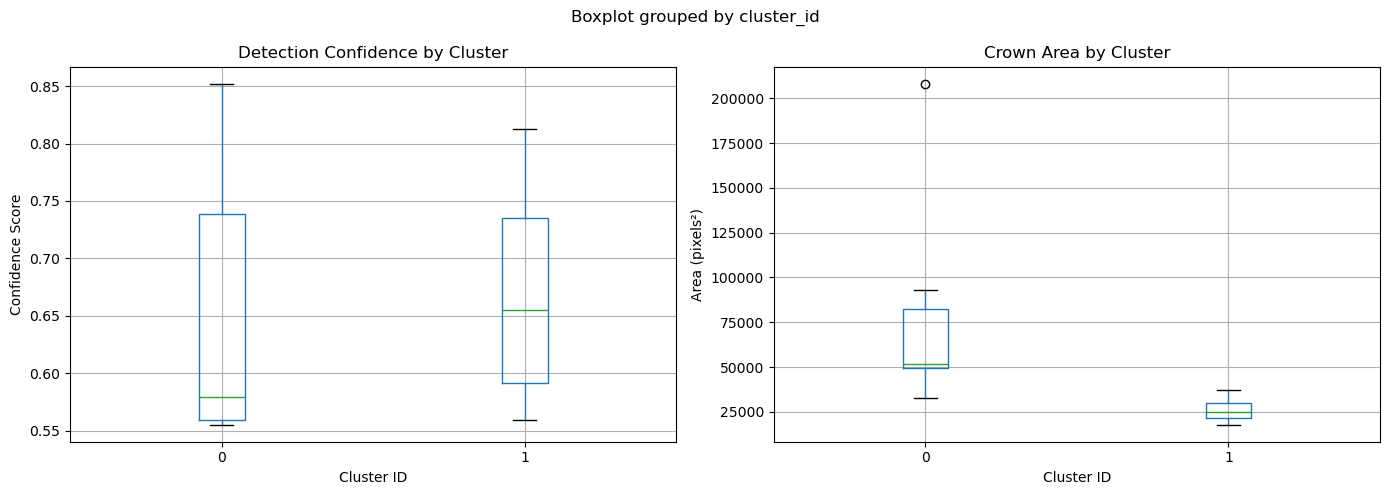

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for easy analysis
df = pd.DataFrame(results_json['annotations'])

print("Cluster Distribution:")
print(df['cluster_id'].value_counts().sort_index())

print("\nConfidence Statistics by Cluster:")
print(df.groupby('cluster_id')['confidence'].describe())

print("\nArea Statistics by Cluster:")
print(df.groupby('cluster_id')['area'].describe())

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence by cluster
df.boxplot(column='confidence', by='cluster_id', ax=axes[0])
axes[0].set_title('Detection Confidence by Cluster')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Confidence Score')

# Area by cluster
df.boxplot(column='area', by='cluster_id', ax=axes[1])
axes[1].set_title('Crown Area by Cluster')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Area (pixels²)')

plt.tight_layout()
plt.show()

<h4>Export Specific Results (Optional)</h4>

In [42]:
# Save cluster-specific data
output_dir = Path(config.output_dir)

# Save annotations by cluster
for cluster_id in df['cluster_id'].unique():
    cluster_df = df[df['cluster_id'] == cluster_id]
    cluster_file = output_dir / f"cluster_{cluster_id}_annotations.csv"
    cluster_df.to_csv(cluster_file, index=False)
    print(f"Saved cluster {cluster_id} annotations to {cluster_file}")

Saved cluster 0 annotations to outputs/test_run/cluster_0_annotations.csv
Saved cluster 1 annotations to outputs/test_run/cluster_1_annotations.csv


<h4>Compare Clustering Methods (Optional)</h4>

In [47]:
# Compare DBSCAN vs HDBSCAN
print("\n" + "="*70)
print("COMPARING CLUSTERING METHODS")
print("="*70)

methods_to_test = ["DBSCAN", "HDBSCAN"]
results_comparison = {}

for method in methods_to_test:
    print(f"\nTesting {method}...")
    
    # Update config
    config.clustering_method = method
    config.output_dir = f"outputs/comparison_{method}"
    
    # Run pipeline
    results, fig = run_pipeline(
        config=config,
        autoencoder_model=autoencoder_model,
        param_grid=None  # Use defaults
    )
    
    # Store results
    results_comparison[method] = {
        'silhouette': results['metadata']['silhouette_score'],
        'n_clusters': len([k for k in results['clusters'].keys() if int(k) != -1]),
        'noise_pct': (results['clusters'].get('-1', {}).get('count', 0) / 
                     len(results['annotations'])) * 100
    }

# Print comparison
print("\n" + "="*70)
print("COMPARISON RESULTS")
print("="*70)
comparison_df = pd.DataFrame(results_comparison).T
print(comparison_df)


COMPARING CLUSTERING METHODS

Testing DBSCAN...
TREE CROWN SEGMENTATION & CLUSTERING PIPELINE
Loading Mask R-CNN from ./[Models] Localizer/latest_checkpoint.ckpt...
✓ Mask R-CNN loaded successfully
Loading Autoencoder from ./[Models] Autoencoders/resnet34_autoencoder.pth...
✓ Autoencoder loaded successfully

Loading image from ./Some-Trees-Dataset-11/valid/2021_FEMMATRICS_tile_007_004_png.rf.97ab90d4b25955938b9500ab7b8e5701.jpg...
✓ Image loaded: (1024, 1024, 3)
Running Mask R-CNN detection...
✓ Detected 10 tree crowns
Cropping individual tree crown masks...
✓ Created 10 mask crops
Extracting latent features from autoencoder...
✓ Extracted features with shape (10, 256)

Optimizing clustering parameters...
Using 10 samples for optimization
⚠ No valid clustering found during optimization. Using default parameters.
✓ Best parameters: {'eps': 2.0, 'min_samples': 2}
✓ Best silhouette score: 0.000

Clustering all 10 samples...
✓ Found 0 clusters
✓ Noise samples: 10 (100.0%)

Creating COCO f

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all

✓ Saved JSON to outputs/comparison_HDBSCAN/results.json

Creating interactive visualization...
✓ Visualization created
✓ Saved interactive visualization to outputs/comparison_HDBSCAN/visualization.html

PIPELINE COMPLETE!

COMPARISON RESULTS
         silhouette  n_clusters  noise_pct
DBSCAN          0.0         0.0      100.0
HDBSCAN         0.0         3.0        0.0


<h4>Visualization Customization (Optional)</h4>

In [48]:
def create_detailed_visualization(results_json, image_path):
    """Create a more detailed visualization with additional plots"""
    
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    from PIL import Image
    
    # Load image
    img = np.array(Image.open(image_path))
    
    # Create figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Clustered Tree Crowns",
            "Cluster Distribution", 
            "Confidence Distribution",
            "Area Distribution"
        ),
        specs=[
            [{"type": "image", "rowspan": 2}, {"type": "bar"}],
            [None, {"type": "box"}]
        ],
        row_heights=[0.5, 0.5],
        column_widths=[0.6, 0.4]
    )
    
    # Add image (implement mask overlay here similar to main visualization)
    fig.add_trace(go.Image(z=img), row=1, col=1)
    
    # Cluster distribution bar chart
    cluster_counts = {k: v['count'] for k, v in results_json['clusters'].items()}
    fig.add_trace(
        go.Bar(
            x=list(cluster_counts.keys()),
            y=list(cluster_counts.values()),
            marker_color=[v['color'] for v in results_json['clusters'].values()]
        ),
        row=1, col=2
    )
    
    # Confidence box plot by cluster
    df = pd.DataFrame(results_json['annotations'])
    for cluster_id in sorted(df['cluster_id'].unique()):
        cluster_data = df[df['cluster_id'] == cluster_id]['confidence']
        fig.add_trace(
            go.Box(
                y=cluster_data,
                name=f"C{cluster_id}",
                marker_color=results_json['clusters'][str(cluster_id)]['color']
            ),
            row=2, col=2
        )
    
    fig.update_layout(
        height=800,
        showlegend=False,
        title_text="Detailed Tree Crown Analysis"
    )
    
    return fig

# Use the custom visualization
detailed_fig = create_detailed_visualization(results_json, config.image_path)
# detailed_fig.show()